In [34]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import scipy.io as sio
from scipy.stats import norm
import shdom
import os

In [35]:
input_dir = '../Develop_Dynamic_cloud/experiments/AirMSPI/dynamic_medium/monochromatic'
measurements = shdom.AirMSPIDynamicMeasurements()
measurements.load_airmspi_measurements(input_dir)
cv_index = 3
if cv_index==3:
    dir_ = '../Develop_Dynamic_cloud/experiments/AirMSPI/dynamic_medium/monochromatic/logs/cvpr_num_mediums_1_cv_3-12-Nov-2020-09:03:44/FINAL_3D_extinction.mat'
if cv_index==10:
    dir_ = '../Develop_Dynamic_cloud/experiments/AirMSPI/dynamic_medium/monochromatic/logs/cvpr_num_mediums_1_cv_10-12-Nov-2020-09:04:18/FINAL_3D_extinction.mat'
if cv_index==17:
    dir_ = '../Develop_Dynamic_cloud/experiments/AirMSPI/dynamic_medium/monochromatic/logs/cvpr_num_mediums_1_cv_17-12-Nov-2020-11:08:01/FINAL_3D_extinction.mat'
data = sio.loadmat(dir_)
extinctions = data['estimated_extinction'][:,:,:,0]


In [36]:
class arg(object):
    def __init__(self):
        self.reff = 10
        self.veff = 0.1
[nx,ny,nz] = extinctions.shape
wavelengths = measurements.wavelength
if not isinstance(wavelengths,list):
    wavelengths = [wavelengths]

grid =  shdom.Grid(bounding_box=measurements.bb,nx=nx,ny=ny,nz=nz)
# mie_table_paths = [
#     '../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) 
#     for wavelength in wavelengths
# ]
# mie = shdom.MiePolydisperse()
# mie.read_table('../mie_tables/polydisperse/Water_659nm.scat')
args= {'reff':10}

cloud_generator = shdom.generate.Homogeneous(arg())
cloud_generator._reff = 10
cloud_generator.add_mie('../mie_tables/polydisperse/Water_659nm.scat')
albedo = cloud_generator.get_albedo(wavelengths[0], grid)
phase = cloud_generator.get_phase(wavelengths[0], grid)
extinction = extinctions
        

Reading mie table from file: ../mie_tables/polydisperse/Water_659nm.scat


In [37]:
df = pd.read_csv('../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))
rayleigh = shdom.Rayleigh(wavelengths[0])
rayleigh.set_profile(temperature_profile.resample(air_grid))
air = shdom.MultispectralScatterer()
air.add_scatterer(rayleigh.get_scatterer())
# scattrer = shdom.OpticalScatterer(wavelengths[0],shdom.GridData(grid,gaussian_extinction_data),albedo,phase)
scattrer = shdom.OpticalScatterer(wavelengths[0],shdom.GridData(grid,extinction),albedo,phase)
dynamicscatterer = shdom.DynamicScatterer()

dynamicscatterer.add_temporary_scatterer(shdom.TemporaryScatterer(scattrer))
dynamicmedium = shdom.DynamicMedium(dynamicscatterer,air)

In [38]:
sun_azimuth_list = measurements.sun_azimuth_list
sun_zenith_list = measurements.sun_zenith_list

surface = shdom.LambertianSurface(albedo=0.04)
scene_params = shdom.SceneParameters(
                    wavelength=wavelengths[0],
                    surface=surface,
                    source=shdom.SolarSource(azimuth=sun_azimuth_list[cv_index], zenith=sun_zenith_list[cv_index])
    
                )
numerical_params = shdom.NumericalParameters(num_mu_bins=8, num_phi_bins=16)
dynamic_solver = shdom.DynamicRteSolver(scene_params=[[scene_params]], numerical_params=[[numerical_params]])
dynamic_solver.set_dynamic_medium(dynamicmedium)
dynamic_solver.solve(100)

adapt_grid_factor reduced to  4.062758524065763


In [39]:
projections = measurements._projections.projection_list[cv_index]
dynamic_proj = shdom.DynamicProjection([projections])
camera = shdom.DynamicCamera(shdom.RadianceSensor(),dynamic_proj)
estimated_image = camera.render(dynamic_solver,72)

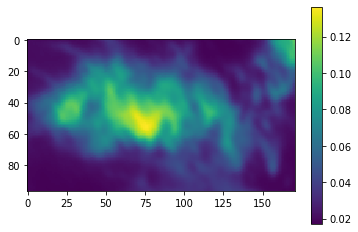

In [40]:
input_image = measurements.images[cv_index]
estimated_image[0][input_image==0]=0
plt.imshow(input_image)
plt.colorbar()

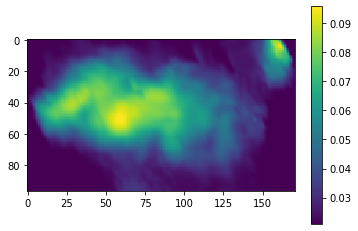

In [41]:
plt.imshow(estimated_image[0])
plt.colorbar()


In [42]:
data = sio.savemat('static_{}.mat'.format(cv_index),{'input_image':input_image, 'estimated_image':estimated_image})
print(np.sum((np.array(estimated_image) - np.array(input_image)).ravel() ** 2))


3.467501
